In [1]:
%%capture
!pip install "gymnasium";
!pip install swig;
!pip install "gymnasium[box2d]";

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

from collections import deque
from copy import deepcopy
from tqdm import tqdm
import gymnasium as gym


In [3]:
# @title ActionValueNetwork class
class ActionValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")

        self.rand_generator = np.random.RandomState(network_config.get("seed"))

        self.layer_sizes = [self.state_dim,self.num_hidden_units,self.num_actions]

        self.weights = [dict() for i in range(0, len(self.layer_sizes) - 1)]
        for i in range(0, len(self.layer_sizes) - 1):
            self.weights[i]['W'] = self.init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights[i]['b'] = np.zeros((1, self.layer_sizes[i + 1]))

    def get_action_values(self, s):
        """
        Args:
            s (Numpy array): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)

        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        q_vals = np.dot(x, W1) + b1

        return q_vals

    def get_TD_update(self, s, delta_mat):
        """
        Args:
            s (Numpy array): The state.
            delta_mat (Numpy array): A 2D array of shape (batch_size, num_actions). Each row of delta_mat
            correspond to one state in the batch. Each row has only one non-zero element
            which is the TD-error corresponding to the action taken.
        Returns:
            The TD update (Array of dictionaries with gradient times TD errors) for the network's weights
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']

        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        dx = (psi > 0).astype(float)

        td_update = [dict() for i in range(len(self.weights))]

        v = delta_mat
        td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
        td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]

        v = np.dot(v, W1.T) * dx
        td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
        td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]

        return td_update

    def init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor

    def get_weights(self):
        """
        Returns:
            A copy of the current weights of this network.
        """
        return deepcopy(self.weights)

    def set_weights(self, weights):
        """
        Args:
            weights (list of dictionaries): Consists of weights that this network will set as its own weights.
        """
        self.weights = deepcopy(weights)

In [4]:
# @title Adam class
class Adam():
    def __init__(self, layer_sizes, optimizer_info):

        self.layer_sizes = layer_sizes

        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")

        self.m = [dict() for i in range(1, len(self.layer_sizes))]
        self.v = [dict() for i in range(1, len(self.layer_sizes))]

        for i in range(0, len(self.layer_sizes) - 1):

            self.m[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.m[i]["b"] = np.zeros((1, self.layer_sizes[i + 1]))
            self.v[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.v[i]["b"] = np.zeros((1, self.layer_sizes[i + 1]))

        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v

    def update_weights(self, weights, td_errors_times_gradients):
        """
        Args:
            weights (Array of dictionaries): The weights of the neural network.
            td_errors_times_gradients (Array of dictionaries): The gradient of the
            action-values with respect to the network's weights times the TD-error
        Returns:
            The updated weights (Array of dictionaries).
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                self.m[i][param] = self.beta_m*self.m[i][param]+(1-self.beta_m)*td_errors_times_gradients[i][param]
                self.v[i][param] = self.beta_v*self.v[i][param]+(1-self.beta_v)*(td_errors_times_gradients[i][param])**2
                m_hat = self.m[i][param]/(1-self.beta_m_product)
                v_hat = self.v[i][param]/(1-self.beta_v_product)
                weight_update = (self.step_size*m_hat)/(self.epsilon+v_hat**0.5)

                weights[i][param] = weights[i][param] + weight_update

        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v

        return weights

In [5]:
# @title ReplayBuffer Class
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator.
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

In [6]:
# @title softmax function
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions).
                       The action-values computed by an action-value network.
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """

    preferences = action_values/tau
    max_preference = np.max(preferences, axis=1)

    reshaped_max_preference = max_preference.reshape((-1, 1))

    exp_preferences = np.exp(preferences-reshaped_max_preference)
    sum_of_exp_preferences = np.sum(exp_preferences, axis=1)

    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))

    action_probs = exp_preferences/reshaped_sum_of_exp_preferences

    action_probs = action_probs.squeeze()
    return action_probs

In [7]:
# @title get_td_error function

def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets,
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """

    q_next_mat = current_q.get_action_values(next_states)

    probs_mat = softmax(q_next_mat, tau)

    v_next_vec = np.max(q_next_mat, axis=1)*(1-terminals)

    target_vec = rewards+discount*v_next_vec

    q_mat = network.get_action_values(states)

    batch_indices = np.arange(q_mat.shape[0])

    q_vec = q_mat[batch_indices, actions]

    delta_vec = target_vec-q_vec

    return delta_vec

In [8]:
# @title optimize_network function
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions,
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets,
                                        and particularly, the action-values at the next-states.
    """

    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]

    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)

    batch_indices = np.arange(batch_size)

    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec


    td_update = network.get_TD_update(states,delta_mat)

    weights = optimizer.update_weights(network.get_weights(),td_update)

    network.set_weights(weights)

In [9]:
# @title Agent class
class Agent:
    def __init__(self):
        self.name = "expected_sarsa_agent"

    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer,
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'],
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']

        self.rand_generator = np.random.RandomState(agent_config.get("seed"))

        self.last_state = None
        self.last_action = None

        self.sum_rewards = 0
        self.episode_steps = 0

    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action.
        """
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

        self.sum_rewards += reward
        self.episode_steps += 1

        state = np.array([state])

        action = self.policy(state)

        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)

        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):

                experiences = self.replay_buffer.sample()

                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)

        self.last_state = state
        self.last_action = action

        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1

        state = np.zeros_like(self.last_state)

        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)

        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):

                experiences = self.replay_buffer.sample()

                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)

    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

In [10]:
# @title save_frames_as_gif function

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif',title="title"):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=144)
    plt.text(0,-5,title,fontsize=20)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save(path + filename, writer='imagemagick', fps=30)

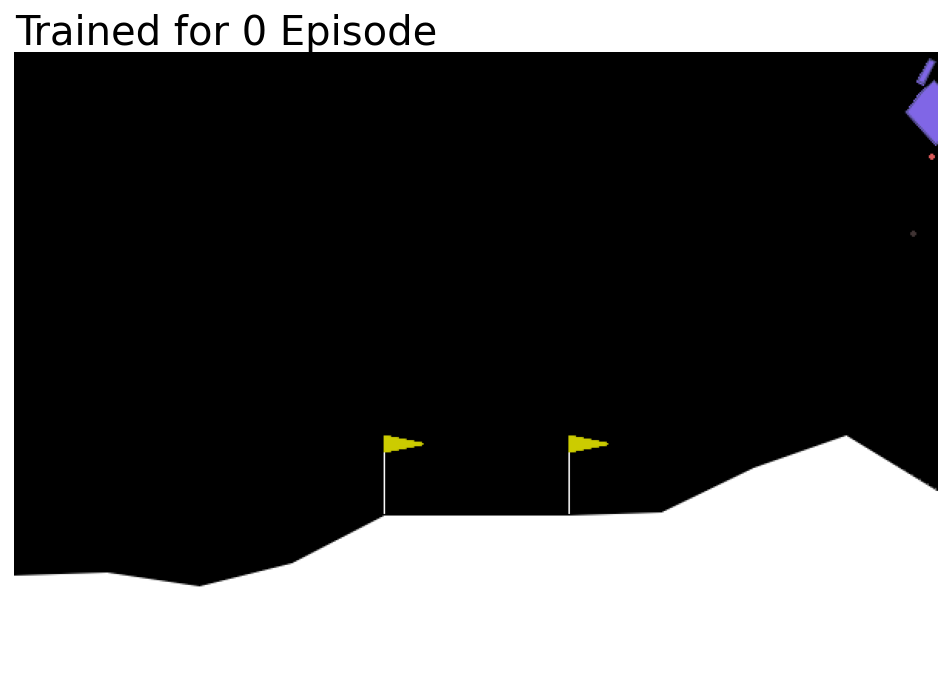

In [11]:
# @title Untrained Agent
env_info = {}
agent_info = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4,
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9,
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 16,
    'num_replay_updates_per_step': 8,
    'gamma': 0.99,
    'tau': 0.001
}
all_steps = []

agent = Agent()
env = gym.make("LunarLander-v2", render_mode="rgb_array")
agent.agent_init(agent_info)
frames = []


for episode in range(1):
    is_terminal = False
    state, info = env.reset(seed=0)
    last_action = agent.agent_start(state)
    while (not is_terminal):
        state, reward, terminated, truncated, info = env.step(last_action)
        last_action = agent.policy(state) # this is where you would insert your policy

        is_terminal = terminated or truncated
        frames.append(env.render())

env.close()
save_frames_as_gif(frames,filename="untrained_q_learning.gif",title="Trained for 0 Episode")

100%|██████████| 500/500 [24:12<00:00,  2.90s/it]


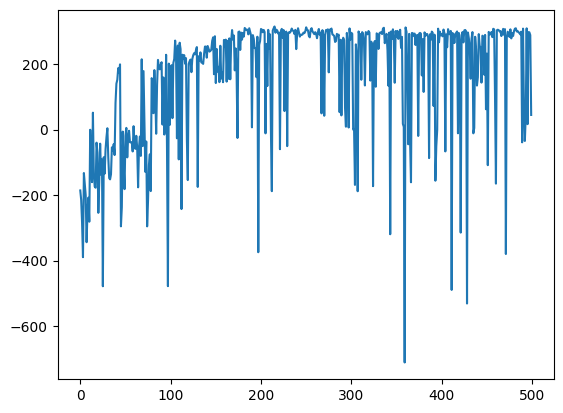

In [12]:
# @title Training the Agent
num_runs = 1
num_episodes = 500

agent_info = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4,
        'seed':0
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9,
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 16,
    'num_replay_updates_per_step': 8,
    'gamma': 0.99,
    'tau': 0.001,
    'seed':0
}
all_total_reward = []


agent = Agent()
env = gym.make("LunarLander-v2")

agent.agent_init(agent_info)
succes_200 = 0

total_reward = 0.0
num_steps = 0
total_reward_per_episode = []
for episode in tqdm(range(1,num_episodes+1)):
    is_terminal = False
    total_reward = 0.0
    num_steps = 1


    first_state,_ = env.reset(seed=0)
    last_action = agent.agent_start(first_state)

    while (not is_terminal) and ((num_steps < 1000)):

        (last_state, reward, terminated, truncated, _) = env.step(last_action)
        total_reward += reward

        if terminated:
            agent.agent_end(reward)
            is_terminal = terminated
        elif truncated:
            last_action = agent.agent_step(reward, last_state)
            is_terminal = truncated
        else:
            num_steps += 1
            last_action = agent.agent_step(reward, last_state)
            is_terminal = terminated

    total_reward_per_episode.append(total_reward)

    # if total_reward > 200 and episode > 300:
    #     succes_200 += 1
    #     if succes_200 == 3:
    #         print(f"Solved at Episode {episode}")
    #         break

all_total_reward.append(np.array(total_reward_per_episode))


mean = np.mean(all_total_reward, axis=0)
plt.plot(mean)

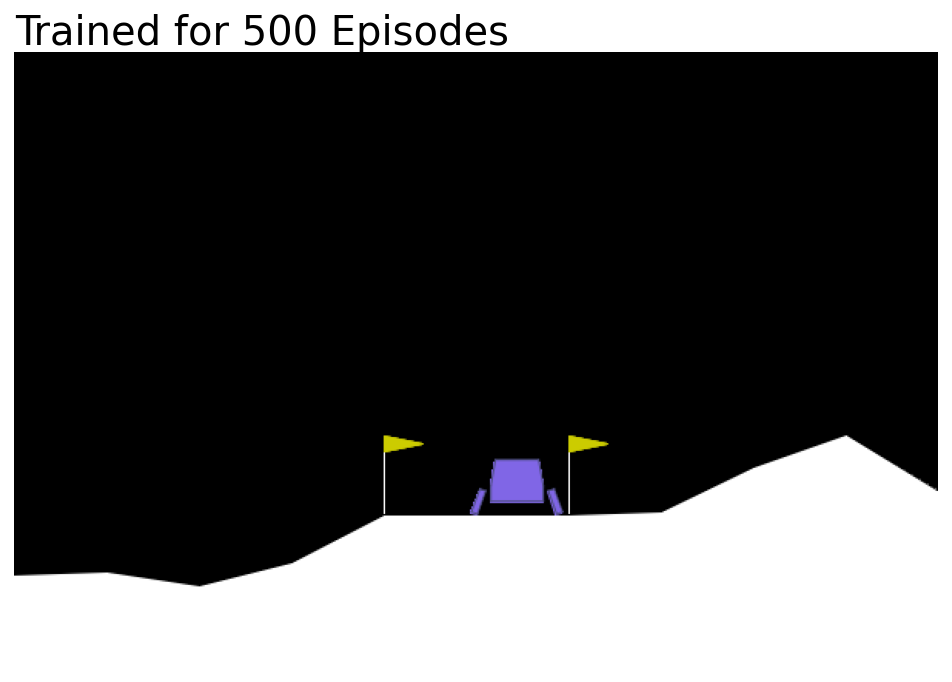

In [13]:
# @title Visualize trained agent
env = gym.make("LunarLander-v2", render_mode="rgb_array")
frames = []

for episode in range(1):
    is_terminal = False
    state, info = env.reset(seed=0)
    last_action = agent.agent_start(state)
    while (not is_terminal):
        state, reward, terminated, truncated, info = env.step(last_action)
        last_action = agent.agent_step(reward, state) # this is where you would insert your policy
        is_terminal = terminated or truncated
        frames.append(env.render())

env.close()
save_frames_as_gif(frames,filename=f"{len(mean)}_episodes_q_learning.gif",title=f"Trained for {len(mean)} Episodes")